# Assessing the added value of a carbon signal for electrical vehicle charging in Eastern Denmark

This analysis is based upon data for Eastern Denmark for the year 2020, and presented in the context of electrical vehicle (EV) charging.

In [1]:
# Convention in this notebook: all the technical explanations are provided as code comments, while the analysis is in the markdown/output part of the notebook

# This imports the methods required to create the database (including import from ENTSO-E) and read the data
from database_io import create_database, read_timeseries

# This imports the methods to compute emission intensity
from emission_intensity import compute_emission_intensity

# This imports the functions used for visualisation
from visualisation import colors, plot_emission_intensity, intensity_traffic_light_plot, plot_difference_dk1_dk2


from datetime import datetime, timedelta
import numpy as np
from IPython.display import display, Markdown
import plotly.graph_objects as go
from typing import Tuple
from plotneat.plotly_addons import prepare_minimalistic_show

In [2]:
# This cell loads the database

# Only set the one below to True of you want to force-refresh the database (else it will only be loaded at first run)
refresh_database = False

# This creates the database in the "data" folder
was_loaded = create_database(skip_if_exists=(not refresh_database), force_refresh=refresh_database)

The database already exists - skipping creation


In [3]:
# This cell reads the timeseries of production from DK2 for 2020
df = read_timeseries("DK2", freq="H")

In [4]:
# This cell computes the emission intensity and adds it to the dataframe
df = compute_emission_intensity(df)

## Why is there a difference between Eastern and Western Denmark?

Eastern and western Denmark are two different power grids, with a very different size and generation characteristics. Geographically, Western Denmark (DK1) covers Jutland and Funen, while eastern Denmark (DK2) covers Sealand. Production-wise, western Denmark has a higher production capacity and typically stronger wind power generation.

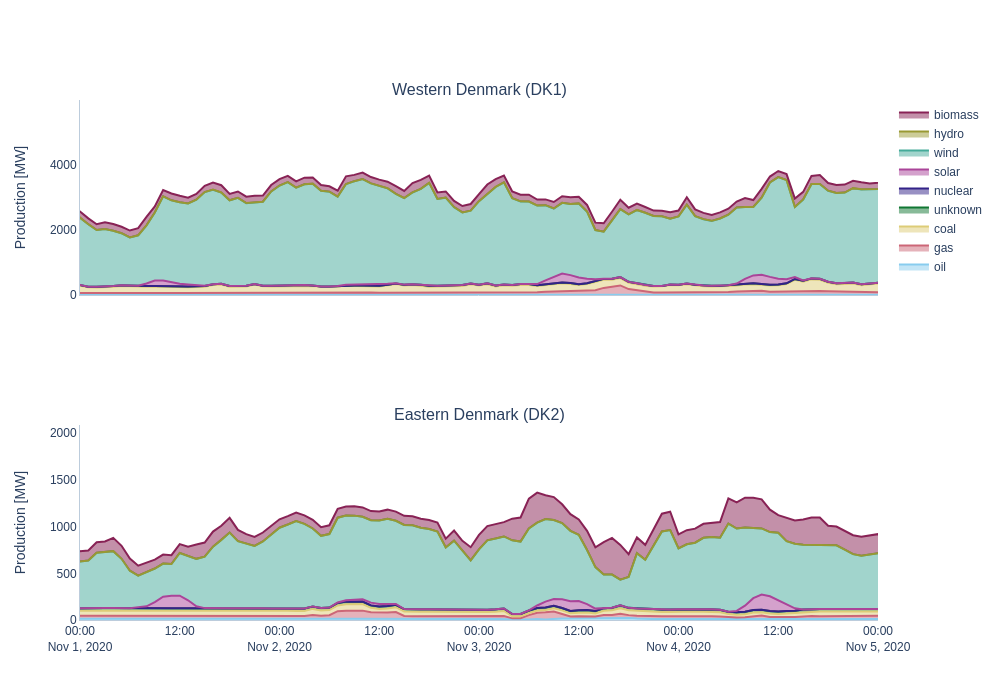

In [5]:
fig_dk12 = plot_difference_dk1_dk2(show=False)
fig_dk12.update_layout(xaxis_range=[datetime(2020, 11, 1), datetime(2020, 11, 5)], width=1000, height=700)
fig_dk12.show("png")

## How do emissions from electrity vary throughout the year in Eastern Denmark?


In Eastern Denmark in 2020, the emission intensity varied between **56** and **586 gCO2-eq/kWh**, with an average of **252 gCO2-eq/kWh**.

The variations over time are presented below, where one can observe strong and fast variations over time. This indicates the need to have an adequate forecast, as the signal is complex.


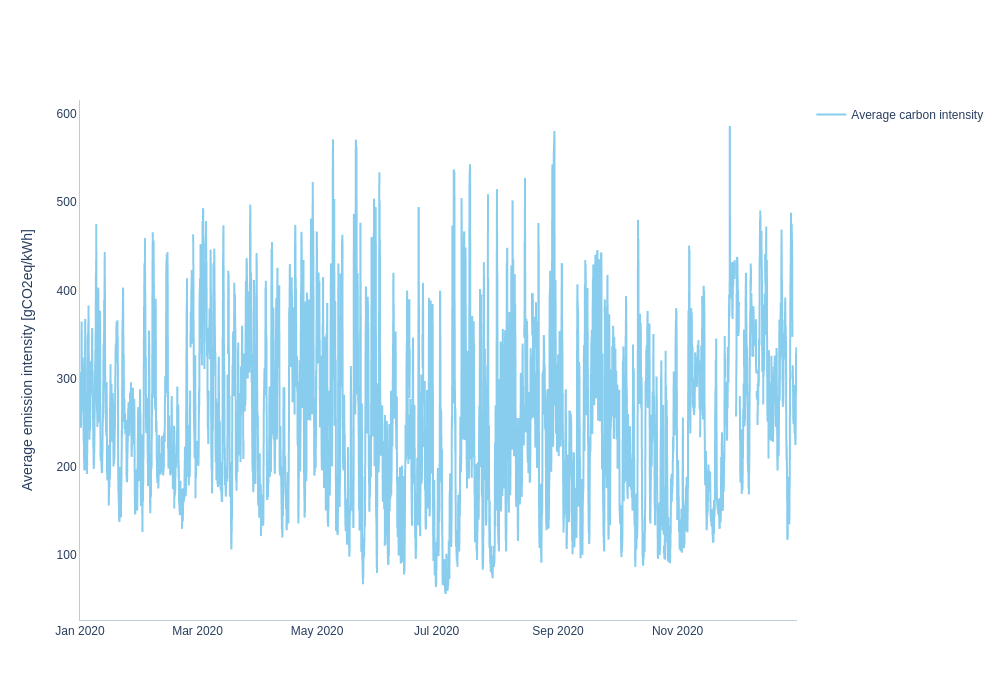

In [6]:

display(Markdown(f"""
In Eastern Denmark in 2020, the emission intensity varied between **{int(df["average_co2_intensity"].min())}** and **{int(df["average_co2_intensity"].max())} gCO2-eq/kWh**, with an average of **{int(df["average_co2_intensity"].mean())} gCO2-eq/kWh**.

The variations over time are presented below, where one can observe strong and fast variations over time. This indicates the need to have an adequate forecast, as the signal is complex.
"""))

fig = plot_emission_intensity(df, show=False)
fig.update_layout(width=1000, height=700)
fig.show("png")


Some days have stronger intra-day variations than others, where the daily minimum emission intensity can be **1.1** to **4.9** times lower than the daily maximum.

This is illustrated in the figure below, showing these maximum/minimum ratio per day over the year.


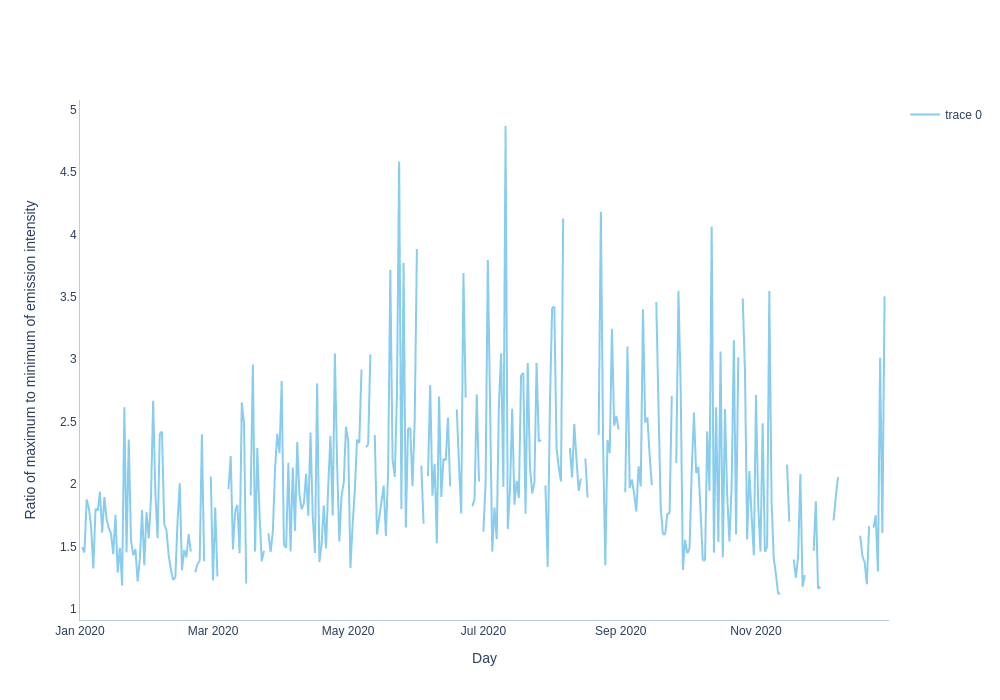

In [7]:
# Min/max ratio within 24h
df["min_intensity_rolling"] = df["average_co2_intensity"].rolling(24).min()
df["max_intensity_rolling"] = df["average_co2_intensity"].rolling(24).max()
df["ratio_max_min"] = df["max_intensity_rolling"] / df["min_intensity_rolling"]

df_day = df.resample("D").nearest()

display(Markdown(f"""
Some days have stronger intra-day variations than others, where the daily minimum emission intensity can be **{np.round(df_day["ratio_max_min"].min(),1)}** to **{np.round(df_day["ratio_max_min"].max(),1)}** times lower than the daily maximum.

This is illustrated in the figure below, showing these maximum/minimum ratio per day over the year.
"""))


fig = go.Figure()
fig.add_trace(go.Scattergl(x=df_day.index, y=df_day["ratio_max_min"]))
fig.update_layout(width=1000, height=700)
fig["layout"]["yaxis"]["title"] = "Ratio of maximum to minimum of emission intensity"
fig["layout"]["xaxis"]["title"] = "Day"

prepare_minimalistic_show(fig)
fig.show("png")

## How can one use this to reduce the impact of EV operation via 'smart charging'?

By using the emission intensity signal to charge the EV fleet at the right times, substantial emission reduction can be achieved.

Below, a small example of potential gains for smart-charging in the DK1 price area is presented, with a simple assumption that the vehicle needs to get a full 6 hour charge every other day. In practice, given more details of the EV fleet to be optimised, this can be refined much further (however, this kind of optimisation is out-of-scope of the current analysis).

### Smart-charging examples on selected periods

#### Performance in a period with high variations

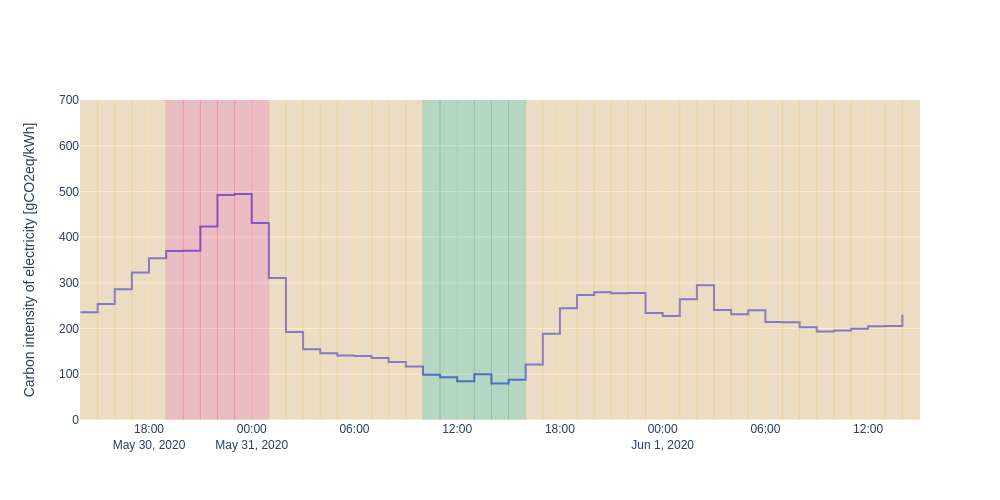



| Average carbon intensity        | g CO2-eq/kWh         | Compared to average |
| ------------------------------- | -------------------- | --------------------|
| in period                       | 230    | / |
| best 6 hours | 	90 |60 % better |
| worst 6 hours | 	430 |86 % worse |
    

#### Performance in a usual period

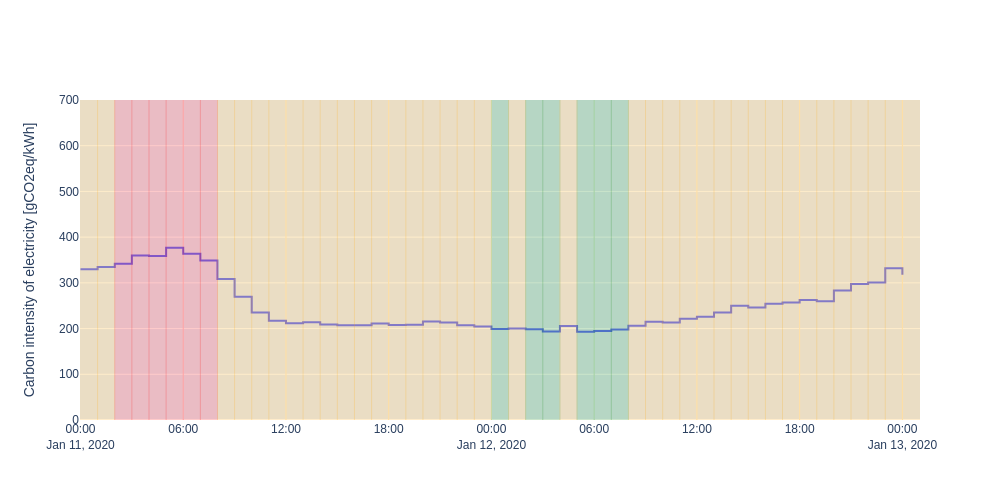



| Average carbon intensity        | g CO2-eq/kWh         | Compared to average |
| ------------------------------- | -------------------- | --------------------|
| in period                       | 251    | / |
| best 6 hours | 	196 |21 % better |
| worst 6 hours | 	358 |42 % worse |
    

In [8]:
n_hours_per_charge = 6

r_min = df["ratio_max_min"].min()
r_median = df["ratio_max_min"].median()
r_max = df["ratio_max_min"].max()

t_min = df["ratio_max_min"].idxmin()
t_max = df["ratio_max_min"].idxmax()
t_median = df[np.abs(df["ratio_max_min"] - r_median)<=0.001].index


def intensity_split_best_avg_worst_to_gCO2eq(df) -> Tuple[float, float, float]:
    # Estimates the impact of 6 hours of charging at best/average/worst times
    ranked_intensity = df["average_co2_intensity"].sort_values().dropna()
    best_hours = ranked_intensity[0:n_hours_per_charge]
    worst_hours = ranked_intensity[-n_hours_per_charge:]
    
    average_gCO2eq = ranked_intensity.mean()
    avg_worst_gCO2eq = worst_hours.mean()
    avg_best_gCO2eq = best_hours.mean()
    return avg_best_gCO2eq, average_gCO2eq, avg_worst_gCO2eq
    

def traffic_light_plot_around_time(df, t, n_hours=n_hours_per_charge):
    # Plots a traffic light plot around a time of interest (+/- 24h)
    t_start = t-timedelta(hours=24)
    t_end = t+timedelta(hours=24)
    df_focus = df[t_start:t_end]
    fig = intensity_traffic_light_plot(df_focus, show=False, n_hours=n_hours)
    fig.update_layout(width=1000, height=500)
    fig.update_yaxes(range = [0, 700])
    fig.show("png")
    
    # Estimates the impact of 6 hours of charging at best/average/worst times
    avg_best, average, avg_worst = intensity_split_best_avg_worst_to_gCO2eq(df_focus)
    
    y_show = lambda x: int(x)
    eval_delta = lambda x, m: int(100 * (x-m)/m)
    md_text = f"""

| Average carbon intensity        | g CO2-eq/kWh         | Compared to average |
| ------------------------------- | -------------------- | --------------------|
| in period                       | {y_show(average)}    | / |
| best {n_hours_per_charge} hours | \t{y_show(avg_best)} |{-eval_delta(avg_best, average)} % better |
| worst {n_hours_per_charge} hours | \t{y_show(avg_worst)} |{eval_delta(avg_worst, average)} % worse |
    """
    display(Markdown(md_text))

    
display(Markdown("### Smart-charging examples on selected periods")) 

# Calling the function twice to illustrate performance on best/average case periods
display(Markdown("#### Performance in a period with high variations")) 
traffic_light_plot_around_time(df, t_max)

display(Markdown("#### Performance in a usual period")) 
traffic_light_plot_around_time(df, t_median[0])

In [9]:
from database_io import START_DATE, END_DATE
import pandas as pd
from datetime import timedelta

charging_power_kw = 6

display(Markdown(f"""
### Carbon reduction through smart-charging over the course of a year

Here, the above methodology to select the best charging times is simulated over the course of the whole year, to evaluate the potential at a yearly level. 
The charging power used in this example is {charging_power_kw} kW (while the charging time is still assumed to be {n_hours_per_charge} hours per charge, at full power).
And the 'baseline' usual charging is chosen to happen with the average emission intensity in the period (this could be refined by using typical time-of-day profiles if client data was available).


"""))

t = pd.date_range(START_DATE, END_DATE, freq="2D")

impact_best = 0
impact_worst = 0
impact_average = 0
n_kwh_per_charge = n_hours_per_charge * charging_power_kw


for t_i in t[:-2]:
    df_focus = df[t_i:t_i + timedelta(hours=47)]    
    avg_best, average, avg_worst = intensity_split_best_avg_worst_to_gCO2eq(df_focus)
    impact_best += n_kwh_per_charge * avg_best
    impact_average += n_kwh_per_charge * average
    impact_worst += n_kwh_per_charge * avg_worst
    
_to_ton_co2eq = 1E6
y_show = lambda x: np.round(x,1)
eval_delta = lambda x, m: int(100 * (x-m)/m)



md_text = f"""
The total impact of charging per vehicle over a year was computed for different strategies: usual charging (charging at random times), best and worst hours in each usage period. 
The results are given in the table below.

| Charging period                 | Yearly footprint (ton CO2eq)           | Compared to usual charging |
| ------------------------------- | -------------------------------------- | ----------- |
| usual (average in period)       | {y_show(impact_average/_to_ton_co2eq)} | /
| best {n_hours_per_charge} hours | {y_show(impact_best/_to_ton_co2eq)}    | {-eval_delta(impact_best, impact_average)} % better
| worst {n_hours_per_charge} hours| {y_show(impact_worst/_to_ton_co2eq)}   | {eval_delta(impact_worst, impact_average)} % worse

"""
display(Markdown(md_text))


### Carbon reduction through smart-charging over the course of a year

Here, the above methodology to select the best charging times is simulated over the course of the whole year, to evaluate the potential at a yearly level. 
The charging power used in this example is 6 kW (while the charging time is still assumed to be 6 hours per charge, at full power).
And the 'baseline' usual charging is chosen to happen with the average emission intensity in the period (this could be refined by using typical time-of-day profiles if client data was available).





The total impact of charging per vehicle over a year was computed for different strategies: usual charging (charging at random times), best and worst hours in each usage period. 
The results are given in the table below.

| Charging period                 | Yearly footprint (ton CO2eq)           | Compared to usual charging |
| ------------------------------- | -------------------------------------- | ----------- |
| usual (average in period)       | 1.7 | /
| best 6 hours | 1.1    | 33 % better
| worst 6 hours| 2.4   | 43 % worse



## Conclusion

This report presented a brief analysis of carbon intensity signals in a Danish context, as well as an application to the value that can be derived from them in the context of electric vehicle charging.

Although the methods used here are much more approximative than the ones used in electricityMap, which relies on algorithms to account for missing data and exchange between zones (among others), the results show that taking into account emission intensity in charging decisions can yield significant emission reduction in the operation of a fleet of EVs compared to usual charging. It also allows mitigating the risks that these EVs would charge at worst times (intensity-wise).